# CASE: Every 30 days a 50 % of the premium obtained is withdrawn

### Libraries import

In [1]:
import random
import sys
from ntpath import join
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import pandas as pd
from IPython.display import display, HTML

### Base scenario values

In [2]:
NUM_SIM = 100
MAX_NUMBER_INVOICES = 500
MIN_PERC_NOT_COLLATERALIZED = 0.05
MAX_PERC_NOT_COLLATERALIZED = 0.49
MIN_INVOICE_REQ_NOT_COL = 100
MAX_INVOICE_REQ_NOT_COL = 2000
PROB_HACK = 0.0
PROB_UNPAID = 0.00 + PROB_HACK
PROB_ADD_LIQUIDITY = 0.0
MIN_LIQUIDITY_ADD = 0
MAX_LIQUIDITY_ADD = 0
MAX_DELAY_INVOICE = 120
MIN_DELAY_INVOICE = 30
MAX_DAYS = 500
ADDITIONAL_DAYS = 30
MAX_DAYS_SIM = MAX_DAYS + MAX_DELAY_INVOICE + ADDITIONAL_DAYS
START_Q_LIQUIDITY = 10000
START_PREM_LIQUIDITY = 0
INITIAL_TOTAL_VOLUME = START_Q_LIQUIDITY + START_PREM_LIQUIDITY

### Premium withdrawn configuration

In [3]:
PREMIUM_WITHDRAW_DAYS = 30 #From 0 to (MAX_DAYS_SIM OR MAX_NUMBER_INVOICES)
PREMIUM_FACTOR = 0.5 # % of premium to withdraw

### Scenario reset function

In [4]:
def reset():
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY = MIN_LIQUIDITY_ADD = MAX_LIQUIDITY_ADD = 0
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = 30, 120
    global PROB_UNPAID
    PROB_UNPAID = 0
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL = 100, 2000
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MIN_PERC_NOT_COLLATERALIZED, MAX_PERC_NOT_COLLATERALIZED = 0.05, 0.49

### Scenario functions

In [5]:
def scenario_1(prob_add_liq, perc_liq_add):
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY, MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD = prob_add_liq, 0, perc_liq_add*START_Q_LIQUIDITY
    print(f"Scenario 1: Increasing Liquidity Through Time with prob. {prob_add_liq*100} % of adding {100*perc_liq_add} % of initial liquidity")

def scenario_2(prob_unpaid):
    global PROB_UNPAID
    PROB_UNPAID = prob_unpaid
    print(f"Scenario 2: More and more Unpaid Invoices. {100*prob_unpaid} % of unpaid invoices")
    
def scenario_3(min_invoice_delay, max_invoice_delay):
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = min_invoice_delay, max_invoice_delay
    print(f"Scenario 3: More and more Delay in the Invoice Payments. Min delay: {min_invoice_delay} days, Max delay: {max_invoice_delay} days")
    
def scenario_4(invoice_amount_not_col):
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL = MAX_INVOICE_REQ_NOT_COL = invoice_amount_not_col*START_Q_LIQUIDITY
    print(f"Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: {100*invoice_amount_not_col} % of initial Q")
    
def scenario_5(invoice_col):
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col
    print(f"Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. {round(100*invoice_col, 0)} %  collateralized")
    
def hack_scenario(prob_hack, invoice_col):
    global PROB_UNPAID
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    PROB_UNPAID = prob_hack
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col
    print(f"Hack Scenario. Hack prob. {100*prob_hack} % with invoices {100*invoice_col} % collateralized")

### Plot aux function

In [6]:
def aux_plot():
    fig = plt.figure(figsize=(15, 25))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    ax.set_title('AMM Q Volume', fontsize=15)
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Volume', fontsize=15) 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium', fontsize=15)
    ax2.set_xlabel('Days', fontsize=15)
    ax2.set_ylabel('Prem', fontsize=15) 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)', fontsize=15)
    ax3.set_xlabel('Days', fontsize=15)
    ax3.set_ylabel('Total Volume', fontsize=15) 
    ax3.set_xlim([0, len(y)])
    
    ax4.set_title('Withdrawn Premium', fontsize=15)
    ax4.set_xlabel('Days', fontsize=15)
    ax4.set_ylabel('Prem', fontsize=15) 
    ax4.set_xlim([0, len(y)])
    
    return ax, ax2, ax3, ax4, y

### Auxiliary result structures

In [7]:
sim_type = ['no_premium_withdrawn', 'premium_withdrawn']

results_params = {
        'collateralized_counter': '',
        'unpaid_invoices': '',
        'unpaid_amount': '',
        'paid_invoices': '',
        'collateralized_amount': '',
        'sum_q_amount': '',
        'total_premium': '',
        'total_volume': '',
        'array_q_volume': '',
        'array_prem': '',
        'array_vol': '',
        'unavailable_days': '',
        'array_accu_prem': '',
        'gain': ''
    }

results_dict = {
    sim_type[0]: results_params,
    sim_type[1]: results_params,
}

### Simulation auxiliary functions

In [8]:
def unpaid_delayed_aux(prob_unpaid):
    probability_delayed = random.random() > prob_unpaid
    if probability_delayed:
        return random.randint(MIN_DELAY_INVOICE, MAX_DELAY_INVOICE)
    else:
        return 100000

def generate_invoices():
    invoices_list = []
    for i in range(0, MAX_NUMBER_INVOICES):
        delay_days = unpaid_delayed_aux(PROB_UNPAID)

        invoices_list.append({
            'id':i,
            'q':round(random.uniform(MIN_PERC_NOT_COLLATERALIZED,MAX_PERC_NOT_COLLATERALIZED), 2),
            'q_amount': random.randint(MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL),
            'delay_days': delay_days,
            'col_when': 0,
            'collateralized': False,
            'paid': False
        })

    return invoices_list

def modify_liquidity_q(amount, total_q_volume):
    total_q_volume += amount
    return total_q_volume

def modify_volume(amount, total_volume):
    total_volume += amount
    return total_volume

def modify_premium(amount, total_premium):
    total_premium += amount
    return total_premium

def get_premium(q_amount, q, total_q_volume, total_premium):
    volume = total_q_volume + total_premium
    prem = round(q*q/(1-q*(1+q_amount/(volume)))*q_amount, 2)
    return prem

def rkAMM(sim_type, PREMIUM_FLAG):
    invoices =  generate_invoices()
    sum_q_amount = 0
    for i in range(len(invoices)):
        sum_q_amount += list(invoices[i].values())[2]
        #print(invoices[i])
    #print("Total collateral to afford", sum_q_amount)
    
    total_premium = START_PREM_LIQUIDITY
    accumulated_premium = START_PREM_LIQUIDITY
    total_q_volume = START_Q_LIQUIDITY
    total_volume = total_premium + total_q_volume
    paid_counter = 0
    collateralized_counter = 0
    collateralized_amount = 0
    unpaid_amount = 0
    unavailable_days = 0
    profit = 0

    array_q_volume = [total_q_volume]
    array_premium = [0]
    array_volume = [total_volume]
    array_accu_premium = [0]

    for i in range(0, MAX_DAYS_SIM):
        prob_liq_added = random.random() < PROB_ADD_LIQUIDITY

        if prob_liq_added:
            liq_added = random.randint(MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD)
            total_q_volume = modify_liquidity_q(liq_added, total_q_volume)
            total_volume = total_q_volume + total_premium
        
        try:
            q = invoices[i]['q']
            q_amount = invoices[i]['q_amount']

            if(total_q_volume >= invoices[i]['q_amount'] and i < len(invoices) and invoices[i]['collateralized'] == False):
                prem = get_premium(invoices[i]['q_amount'], q, total_q_volume, total_premium)
                total_premium = modify_premium(prem, total_premium)
                total_q_volume = modify_liquidity_q(-invoices[i]['q_amount'], total_q_volume)
                total_volume = total_q_volume + total_premium
                                    
                collateralized_counter += 1
                invoices[i]['collateralized'] = True
                invoices[i]['col_when'] = i

                collateralized_amount += invoices[i]['q_amount']
                unpaid_amount += invoices[i]['q_amount']
                
            elif(total_q_volume < invoices[i]['q_amount'] and total_volume > invoices[i]['q_amount'] and i < len(invoices) and invoices[i]['collateralized'] == False):
                
                prem = get_premium(invoices[i]['q_amount'], q, total_q_volume, total_premium)
                total_premium = modify_premium(prem, total_premium)
                
                partial_q_amount = invoices[i]['q_amount'] - total_q_volume
                total_premium = modify_premium(-partial_q_amount, total_premium)
                total_q_volume = 0
                
                total_volume = total_q_volume + total_premium
                
                collateralized_counter += 1
                invoices[i]['collateralized'] = True
                invoices[i]['col_when'] = i

                collateralized_amount += invoices[i]['q_amount']
                unpaid_amount += invoices[i]['q_amount']
            else:
                unavailable_days += 1
                    
            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpaid_amount -= j['q_amount']
                
        except:
            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpaid_amount -= j['q_amount']
        
        if PREMIUM_FLAG and (i % PREMIUM_WITHDRAW_DAYS == 0) and total_premium > 0:
            accumulated_premium += PREMIUM_FACTOR*total_premium
            total_premium = modify_premium(-PREMIUM_FACTOR*total_premium, total_premium)
        
        array_q_volume.append(total_q_volume)
        array_premium.append(total_premium)
        total_volume = total_q_volume + total_premium
        array_volume.append(total_volume)
        array_accu_premium.append(accumulated_premium)
        profit = (total_q_volume + total_premium - START_Q_LIQUIDITY) + (accumulated_premium)

    values_for_dict = [collateralized_counter, (collateralized_counter-paid_counter), unpaid_amount, paid_counter, collateralized_amount, sum_q_amount, total_premium, total_volume, array_q_volume, array_premium, array_volume, unavailable_days, array_accu_premium, profit]
    for index, key in enumerate(results_dict[sim_type].keys()):
        results_dict[sim_type][key] = values_for_dict[index]

    return collateralized_counter, (collateralized_counter-paid_counter), unpaid_amount, paid_counter, collateralized_amount, sum_q_amount, total_premium, total_volume, array_q_volume, array_premium, array_volume, unavailable_days, array_accu_premium, profit

### Result generation function

In [9]:
def result():
    
    col, imp, total_loss, paid, total_to_col, total_q, total_prem, total_vol, array_q_vol, array_prem, array_vol, un_days, array_accu_prem, gain = ([] for i in range(14))
    arr_q_volume_values, arr_prem_values, arr_volume_values, arr_accu_prem_values = ([] for i in range(4))

    df = pd.DataFrame()

    for index, simulation in enumerate(sim_type):
        if(simulation == 'no_premium_withdrawn'):
            PREMIUM_FLAG = False
        elif(simulation == 'premium_withdrawn'):
            PREMIUM_FLAG = True
        else:
            print("Error")
            break
        
        for i in range(0, NUM_SIM):
            results = rkAMM(simulation, PREMIUM_FLAG)
                        
            col.append(results_dict[simulation]['collateralized_counter'])
            imp.append(results_dict[simulation]['unpaid_invoices'])
            total_loss.append(results_dict[simulation]['unpaid_amount'])
            paid.append(results_dict[simulation]['paid_invoices'])
            total_to_col.append(results_dict[simulation]['collateralized_amount'])
            total_q.append(results_dict[simulation]['sum_q_amount'])
            total_prem.append(results_dict[simulation]['total_premium'])
            total_vol.append(results_dict[simulation]['total_volume'])
            array_q_vol.append(results_dict[simulation]['array_q_volume']) 
            array_prem.append(results_dict[simulation]['array_prem'])
            array_vol.append(results_dict[simulation]['array_vol'])
            un_days.append(results_dict[simulation]['unavailable_days'])
            array_accu_prem.append(results_dict[simulation]['array_accu_prem'])
            gain.append(results_dict[simulation]['gain'])

        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]

        array_accu_prem = [sum(x) for x in zip(*array_accu_prem)]
        accu_prem_values = [x / NUM_SIM for x in array_accu_prem]

        data_names = ["Number of simulations", "Simulation time period (days)", "Total of invoices", "Average of accepted invoices (collateralized)", "% of accepted invoices (collateralized)", "Average of paid invoices (capital returned)", "% of paid invoices (capital returned)", "Average of unpaid invoices (capital not returned)", "% of unpaid invoices (capital not returned)", "Average loss due to unpaid invoices", "Total collateral covered", "Total collateral covered x (i.c.)", "Total premium withdrawn", "Total premium withdrawn x (i.c.)", "Remaining AMM premium", "Remaining AMM premium x (i.c.)", "Final AMM volume", "AMM profit", "AMM profit percentage"]

        data = [
            ["Number of simulations", int(NUM_SIM)],
            ["Simulation time period (days)", int(MAX_DAYS_SIM)],
            ["Total of invoices", int(MAX_NUMBER_INVOICES)],
            ["Average of accepted invoices (collateralized)", round(sum(col)/NUM_SIM, 2)],
            ["% of accepted invoices (collateralized)", round((100*sum(col)/NUM_SIM)/MAX_NUMBER_INVOICES, 2)],
            ["Average of paid invoices (capital returned)", round(sum(paid)/NUM_SIM, 2)],
            ["% of paid invoices (capital returned)", round((100*sum(paid)/NUM_SIM)/(sum(col)/NUM_SIM), 2)],
            ["Average of unpaid invoices (capital not returned)", round(sum(imp)/NUM_SIM, 2)],
            ["% of unpaid invoices (capital not returned)", round((100*sum(imp)/NUM_SIM)/(sum(col)/NUM_SIM), 2)],
            ["Average loss due to unpaid invoices", round(sum(total_loss)/NUM_SIM, 2)],
            ["Total collateral covered", round(sum(total_to_col)/NUM_SIM, 2)],
            ["Total collateral covered x (i.c.)", round((sum(total_to_col)/NUM_SIM)/START_Q_LIQUIDITY, 2)],
            ["Total premium withdrawn", round((array_accu_prem[len(array_accu_prem)-1])/NUM_SIM, 2)],
            ["Total premium withdrawn x (i.c.)", round(round((array_accu_prem[len(array_accu_prem)-1])/NUM_SIM, 2)/START_Q_LIQUIDITY, 2)],
            ["Remaining AMM premium", round(sum(total_prem)/NUM_SIM, 2)],
            ["Remaining AMM premium x (i.c.)", round(round(sum(total_prem)/NUM_SIM, 2)/START_Q_LIQUIDITY, 2)],
            ["Final AMM volume", round(sum(total_vol)/NUM_SIM, 2)],
            ["AMM profit", round((sum(gain)/NUM_SIM), 2)],
            ["% AMM profit", round((sum(gain)/NUM_SIM)*100 / INITIAL_TOTAL_VOLUME, 2)],
        ] 
    
        arr_q_volume_values.append(q_volume_values)
        arr_prem_values.append(prem_values)
        arr_volume_values.append(volume_values)
        arr_accu_prem_values.append(accu_prem_values)   

        df1 = pd.DataFrame()
        df1 = pd.DataFrame(data[0:], columns=data[0])
        df1 = df1.drop(df1.columns[[0]], axis = 1)
        df[index] = df1
    
        col, imp, total_loss, paid, total_to_col, total_q, total_prem, total_vol, array_q_vol, array_prem, array_vol, un_days, array_accu_prem, gain = ([] for i in range(14))
        
    df.columns = ['No Premium Withdrawn', 'Premium Withdrawn']
    df.insert(loc = 0, column = 'Description', value = data_names)
    df.insert(loc = 3, column = "Premium vs. No Premium Withdrawn", value = round((df['Premium Withdrawn']/df['No Premium Withdrawn'] - 1) * 100, 2))
    df.fillna(0, inplace=True)
    df.replace([-np.inf, np.inf], [-100, 100], inplace=True)
           
    df['No Premium Withdrawn'] = df['No Premium Withdrawn'].apply('{:,}'.format)
    df['Premium Withdrawn'] = df['Premium Withdrawn'].apply('{:,}'.format)

    df['No Premium Withdrawn'] = df['No Premium Withdrawn'].astype(str)
    df['Premium Withdrawn'] = df['Premium Withdrawn'].astype(str)
    df['Premium vs. No Premium Withdrawn'] = df['Premium vs. No Premium Withdrawn'].astype(str) + '%'
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    display(df)
    
    pd.reset_option('display.float_format')
        
    return arr_q_volume_values, arr_prem_values, arr_volume_values, arr_accu_prem_values

### Values for each scenario

In [10]:
values_scenario1 = [(0.5, 0.01), (0.5, 0.05), (0.5, 0.1), (0.5, 0.25)]
values_scenario2 = [0.02, 0.05, 0.2]
values_scenario3 = [(30, 60), (60, 90), (90, 120)]
values_scenario4 = [0.01, 0.1, 0.25]
values_scenario5 = [0.55, 0.75, 0.9]
values_hack_scenario = [(0.1, 0.51), (0.1, 0.7), (0.1, 0.9), (0.5, 0.51), (0.5, 0.7), (0.5, 0.9), (1.0, 0.51), (1.0, 0.7), (1.0, 0.9)]

### Scenario descriptions

- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 1.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 5.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 10.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 25.0 % of initial liquidity
<br>

- Scenario 2: More and more Unpaid Invoices. 2.0 % of unpaid invoices
- Scenario 2: More and more Unpaid Invoices. 5.0 % of unpaid invoices
- Scenario 2: More and more Unpaid Invoices. 20.0 % of unpaid invoices
<br>

- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 30 days, Max delay: 60 days
- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 60 days, Max delay: 90 days
- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 90 days, Max delay: 120 days
<br>

- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 1.0 % of initial Q
- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 10.0 % of initial Q
- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 25.0 % of initial Q
<br>

- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 55.0 %  collateralized
- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 75.0 %  collateralized
- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 90.0 %  collateralized

### Scenario 1 simulation

Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 1.0 % of initial liquidity


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),349.36,332.38,-4.86%
4,% of accepted invoices (collateralized),69.87,66.48,-4.85%
5,Average of paid invoices (capital returned),349.36,332.38,-4.86%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 5.0 % of initial liquidity


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),436.16,428.99,-1.64%
4,% of accepted invoices (collateralized),87.23,85.8,-1.64%
5,Average of paid invoices (capital returned),436.16,428.99,-1.64%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 10.0 % of initial liquidity


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),467.61,464.49,-0.67%
4,% of accepted invoices (collateralized),93.52,92.9,-0.66%
5,Average of paid invoices (capital returned),467.61,464.49,-0.67%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 25.0 % of initial liquidity


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),495.14,494.94,-0.04%
4,% of accepted invoices (collateralized),99.03,98.99,-0.04%
5,Average of paid invoices (capital returned),495.14,494.94,-0.04%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


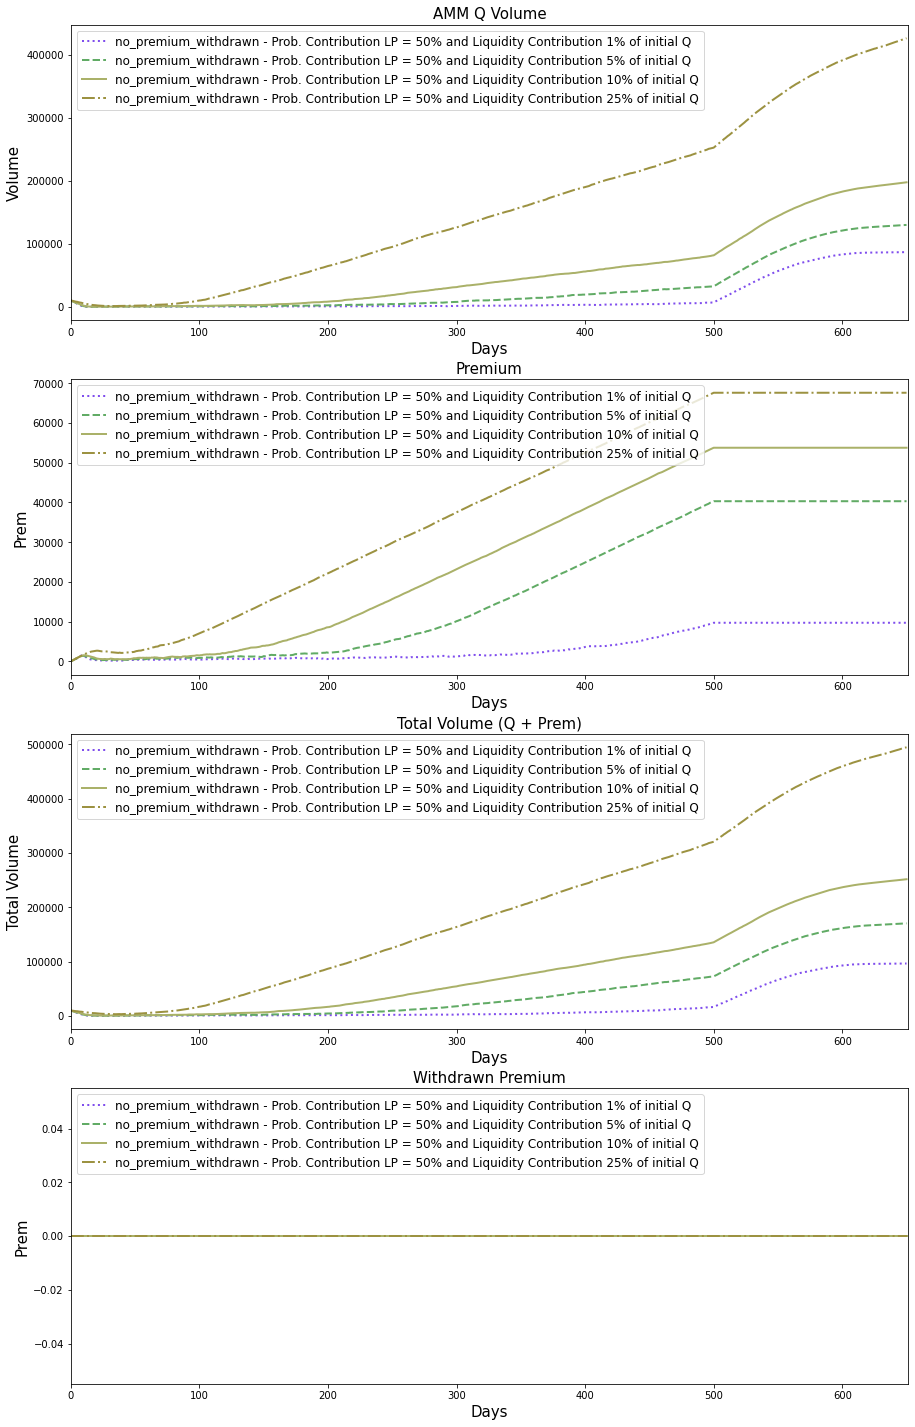

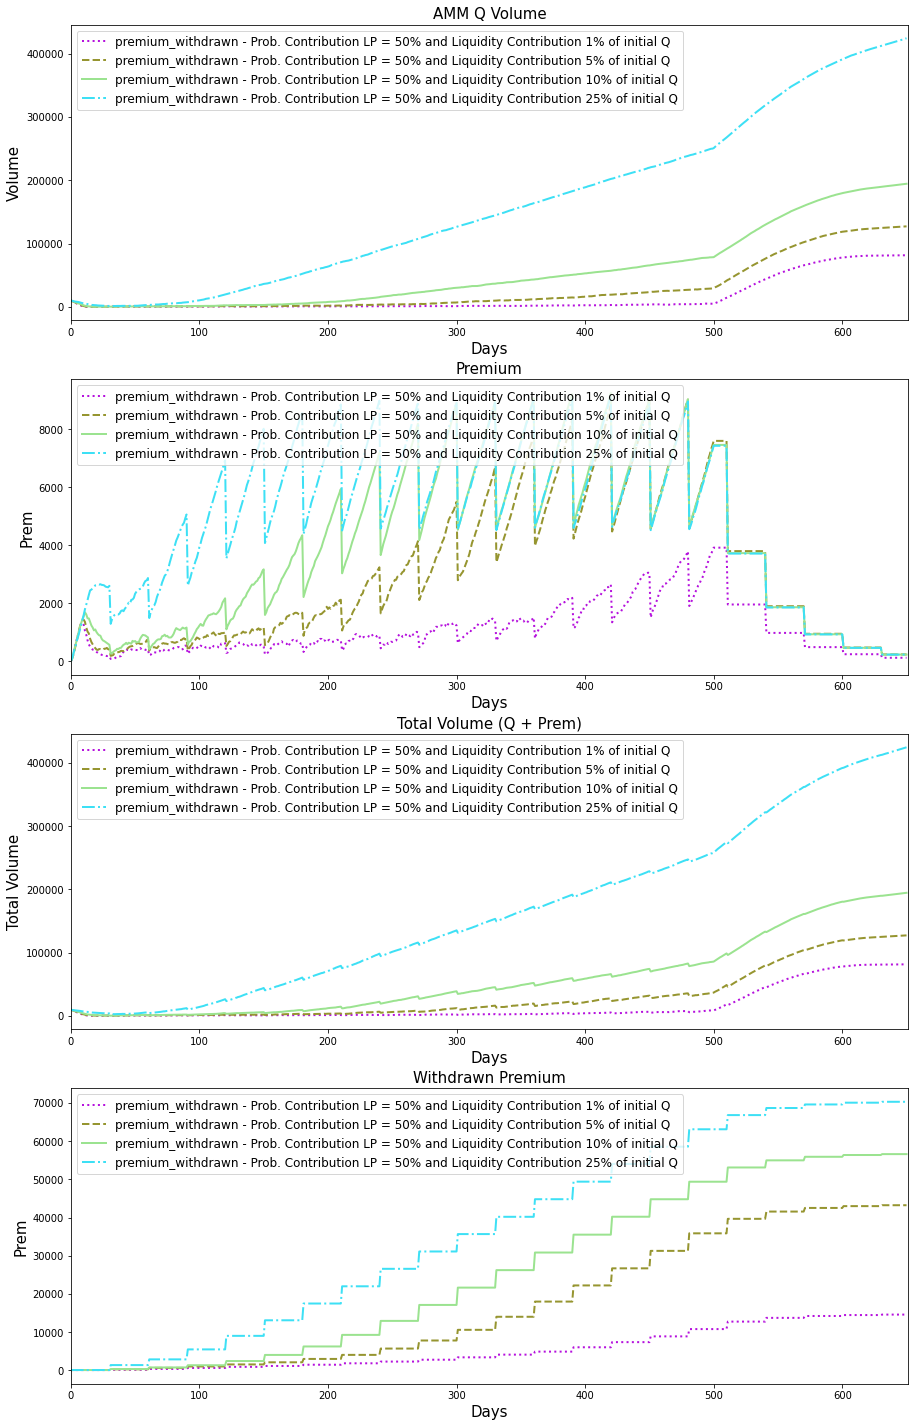

In [11]:
def aux_scenario1(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_1(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
            linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0, (3,5,1,5,1,5))]

            label_value = f"{sim_name} - Prob. Contribution LP = {int(i[0]*100)}% and Liquidity Contribution {int(i[1]*100)}% of initial Q"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

        plt.show()

aux_scenario1(values_scenario1)
reset()

### Scenario 2 simulation

Scenario 2: More and more Unpaid Invoices. 2.0 % of unpaid invoices


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),281.08,255.06,-9.26%
4,% of accepted invoices (collateralized),56.22,51.01,-9.27%
5,Average of paid invoices (capital returned),275.33,249.89,-9.24%
6,% of paid invoices (capital returned),97.95,97.97,0.02%
7,Average of unpaid invoices (capital not returned),5.75,5.17,-10.09%
8,% of unpaid invoices (capital not returned),2.05,2.03,-0.98%
9,Average loss due to unpaid invoices,"4,783.66","4,296.6",-10.18%


Scenario 2: More and more Unpaid Invoices. 5.0 % of unpaid invoices


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),260.92,246.52,-5.52%
4,% of accepted invoices (collateralized),52.18,49.3,-5.52%
5,Average of paid invoices (capital returned),248.24,234.75,-5.43%
6,% of paid invoices (capital returned),95.14,95.23,0.09%
7,Average of unpaid invoices (capital not returned),12.68,11.77,-7.18%
8,% of unpaid invoices (capital not returned),4.86,4.77,-1.85%
9,Average loss due to unpaid invoices,"10,797.64","9,685.49",-10.3%


Scenario 2: More and more Unpaid Invoices. 20.0 % of unpaid invoices


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),180.87,159.93,-11.58%
4,% of accepted invoices (collateralized),36.17,31.99,-11.56%
5,Average of paid invoices (capital returned),144.77,128.05,-11.55%
6,% of paid invoices (capital returned),80.04,80.07,0.04%
7,Average of unpaid invoices (capital not returned),36.1,31.88,-11.69%
8,% of unpaid invoices (capital not returned),19.96,19.93,-0.15%
9,Average loss due to unpaid invoices,"25,532.95","21,884.3",-14.29%


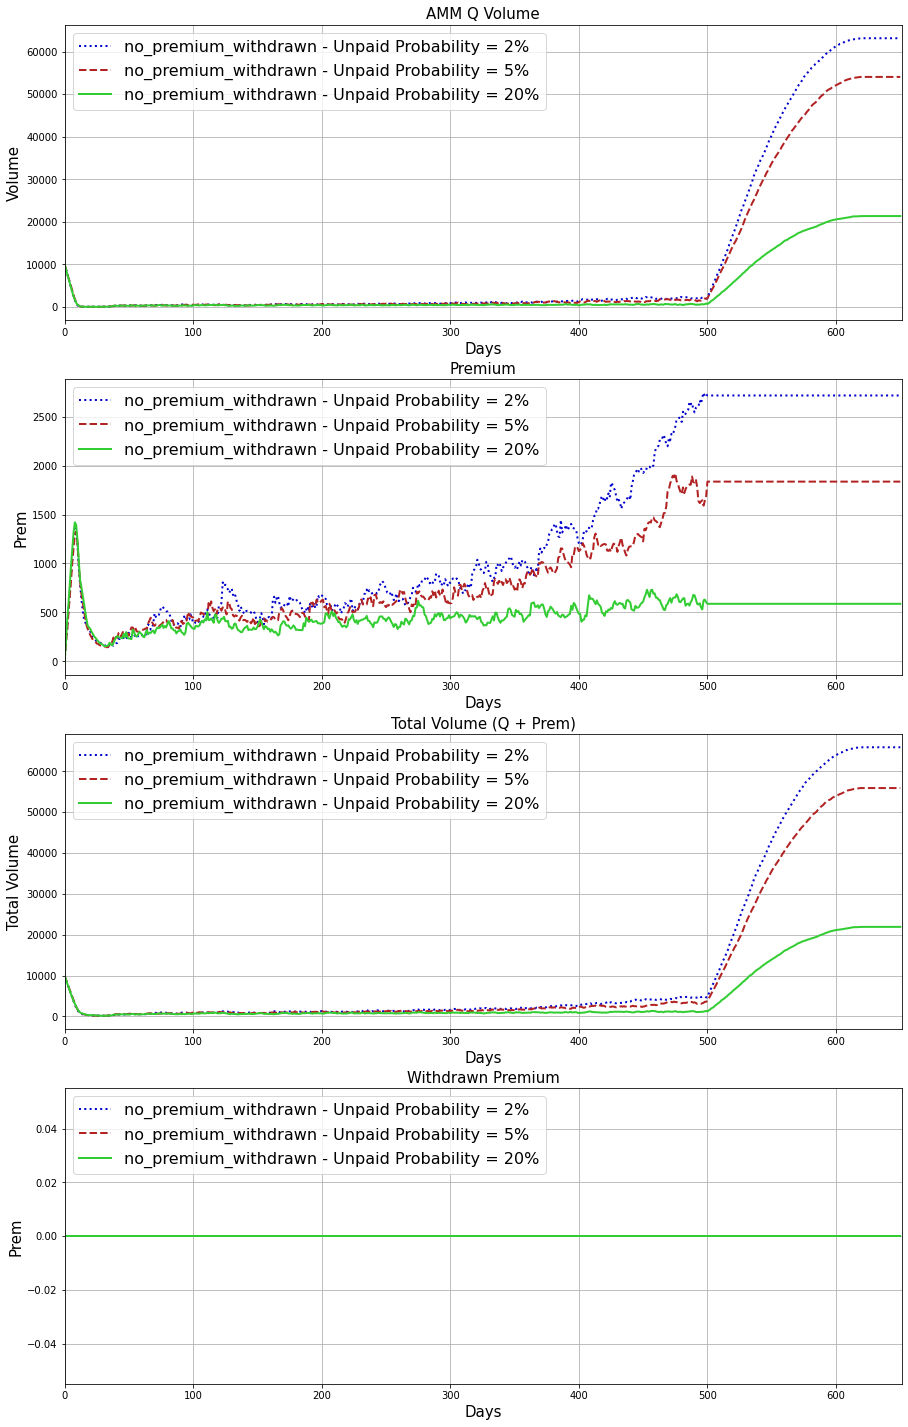

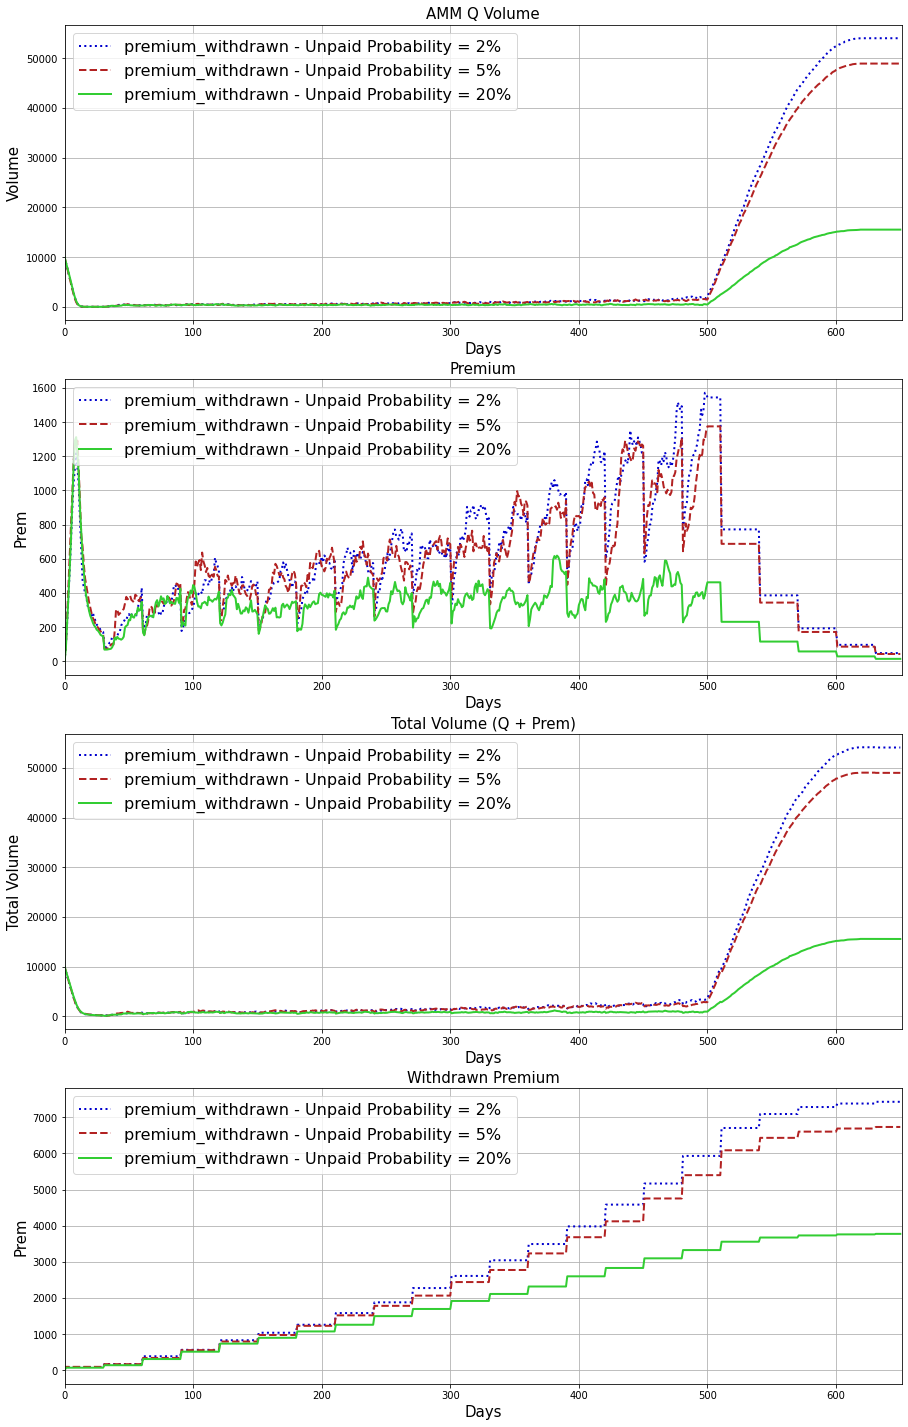

In [12]:
def aux_scenario2(list_values):
    
    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_2(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Unpaid Probability = {int(i*100)}%"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario2(values_scenario2)
reset()

### Scenario 3 simulation

Scenario 3: More and more Delay in the Invoice Payments. Min delay: 30 days, Max delay: 60 days


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),409.94,389.01,-5.11%
4,% of accepted invoices (collateralized),81.99,77.8,-5.11%
5,Average of paid invoices (capital returned),409.94,389.01,-5.11%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 3: More and more Delay in the Invoice Payments. Min delay: 60 days, Max delay: 90 days


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),268.72,239.88,-10.73%
4,% of accepted invoices (collateralized),53.74,47.98,-10.72%
5,Average of paid invoices (capital returned),268.72,239.88,-10.73%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 3: More and more Delay in the Invoice Payments. Min delay: 90 days, Max delay: 120 days


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),159.46,145.47,-8.77%
4,% of accepted invoices (collateralized),31.89,29.09,-8.78%
5,Average of paid invoices (capital returned),159.46,145.47,-8.77%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


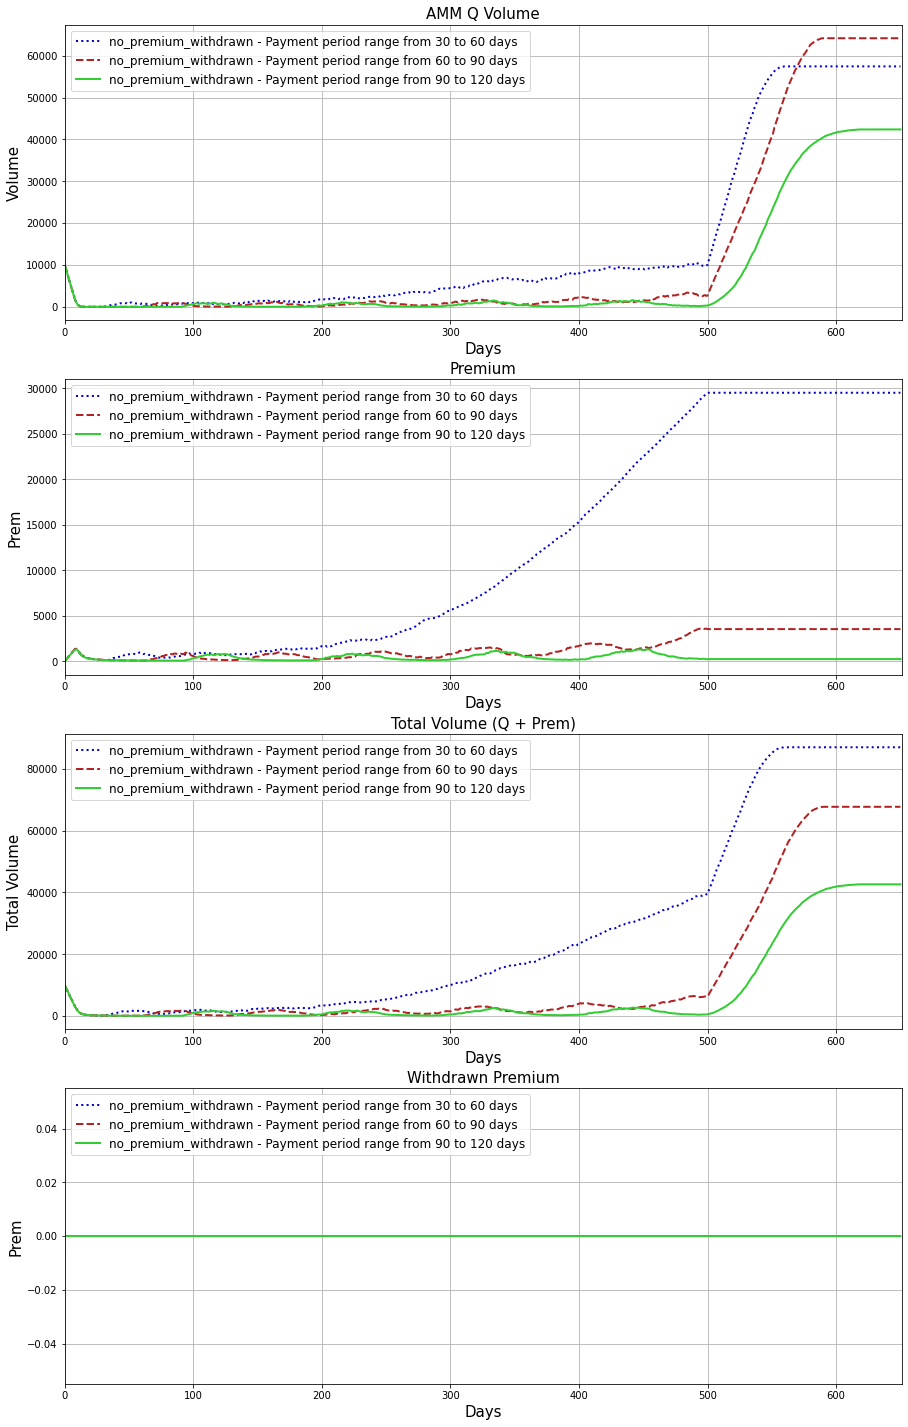

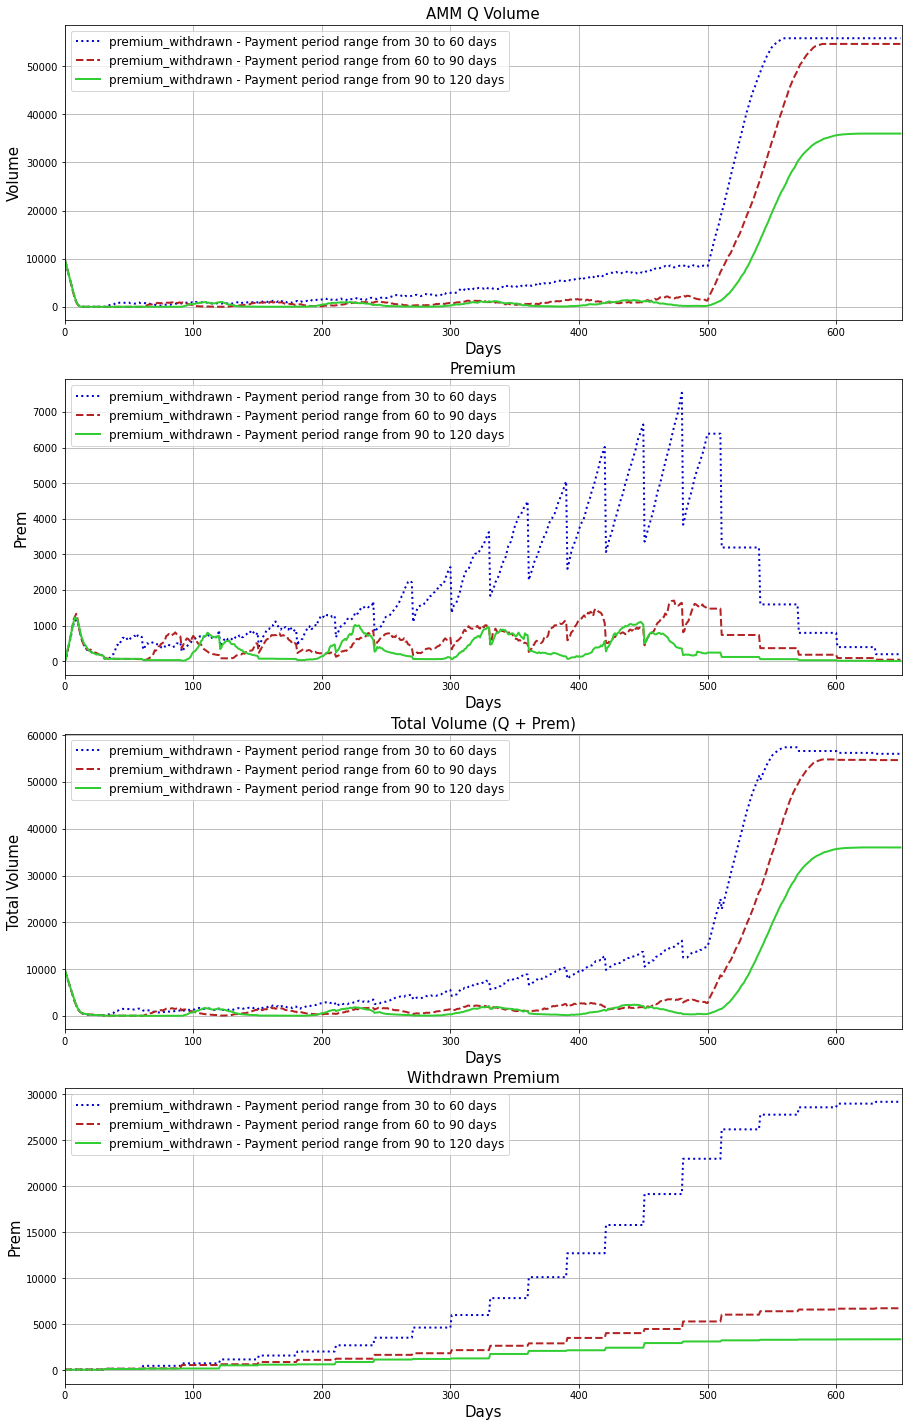

In [13]:
def aux_scenario3(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_3(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Payment period range from {int(i[0])} to {int(i[1])} days"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

        plt.show()

aux_scenario3(values_scenario3)
reset()

### Scenario 4 simulation

Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 1.0 % of initial Q


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),500.0,500.0,0.0%
4,% of accepted invoices (collateralized),100.0,100.0,0.0%
5,Average of paid invoices (capital returned),500.0,500.0,0.0%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 10.0 % of initial Q


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),241.86,209.26,-13.48%
4,% of accepted invoices (collateralized),48.37,41.85,-13.48%
5,Average of paid invoices (capital returned),241.86,209.26,-13.48%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 25.0 % of initial Q


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),113.89,77.15,-32.26%
4,% of accepted invoices (collateralized),22.78,15.43,-32.27%
5,Average of paid invoices (capital returned),113.89,77.15,-32.26%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


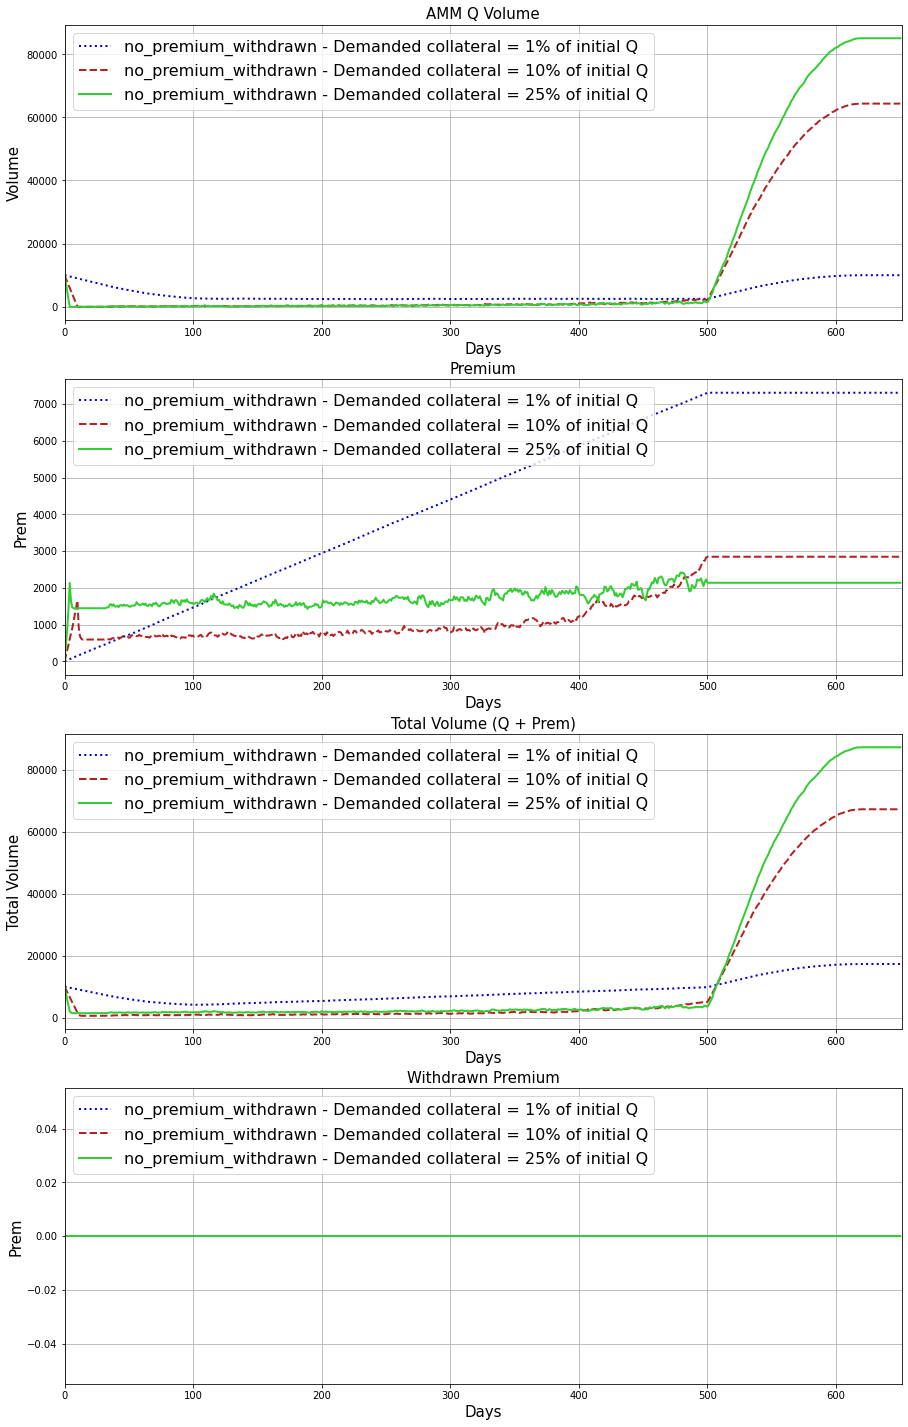

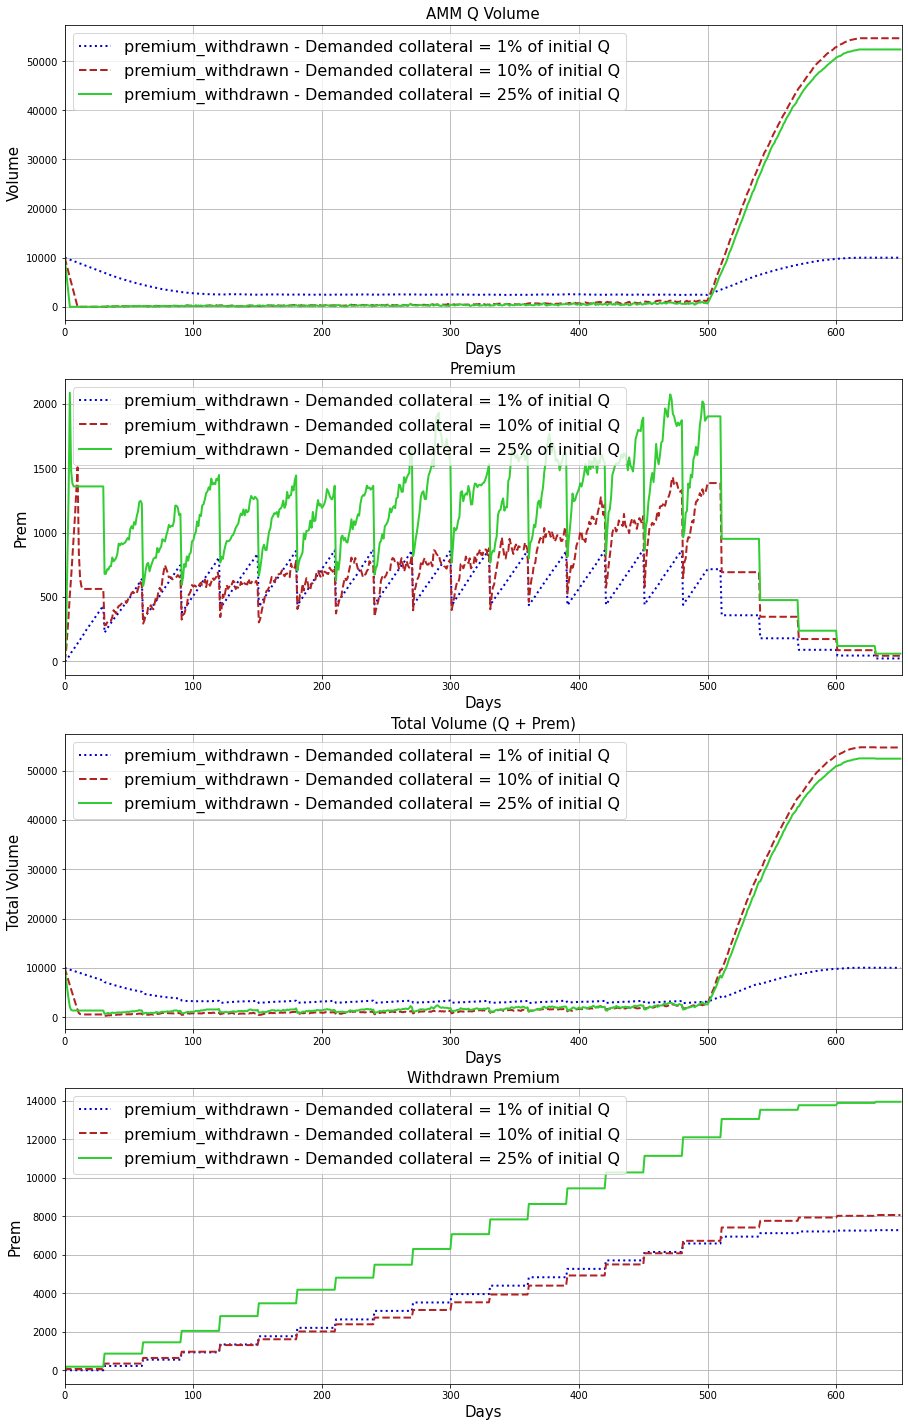

In [14]:
def aux_scenario4(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_4(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Demanded collateral = {int(i*100)}% of initial Q"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario4(values_scenario4)
reset()

### Scenario 5 simulation

Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 55.0 %  collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),484.49,479.12,-1.11%
4,% of accepted invoices (collateralized),96.9,95.82,-1.11%
5,Average of paid invoices (capital returned),484.49,479.12,-1.11%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 75.0 %  collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),163.22,152.47,-6.59%
4,% of accepted invoices (collateralized),32.64,30.49,-6.59%
5,Average of paid invoices (capital returned),163.22,152.47,-6.59%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 90.0 %  collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),118.64,116.65,-1.68%
4,% of accepted invoices (collateralized),23.73,23.33,-1.69%
5,Average of paid invoices (capital returned),118.64,116.65,-1.68%
6,% of paid invoices (capital returned),100.0,100.0,0.0%
7,Average of unpaid invoices (capital not returned),0.0,0.0,0.0%
8,% of unpaid invoices (capital not returned),0.0,0.0,0.0%
9,Average loss due to unpaid invoices,0.0,0.0,0.0%


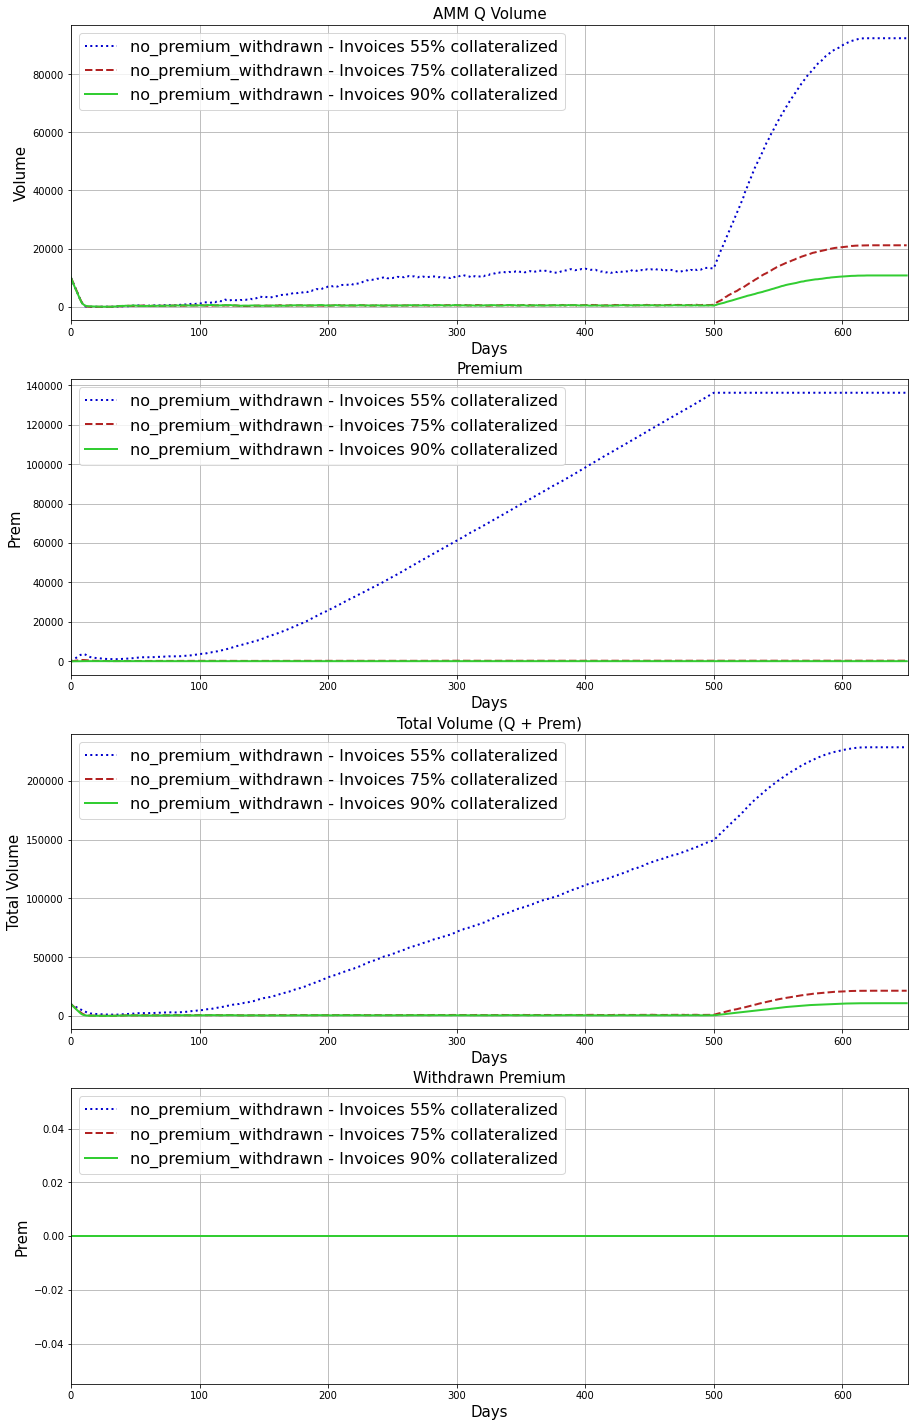

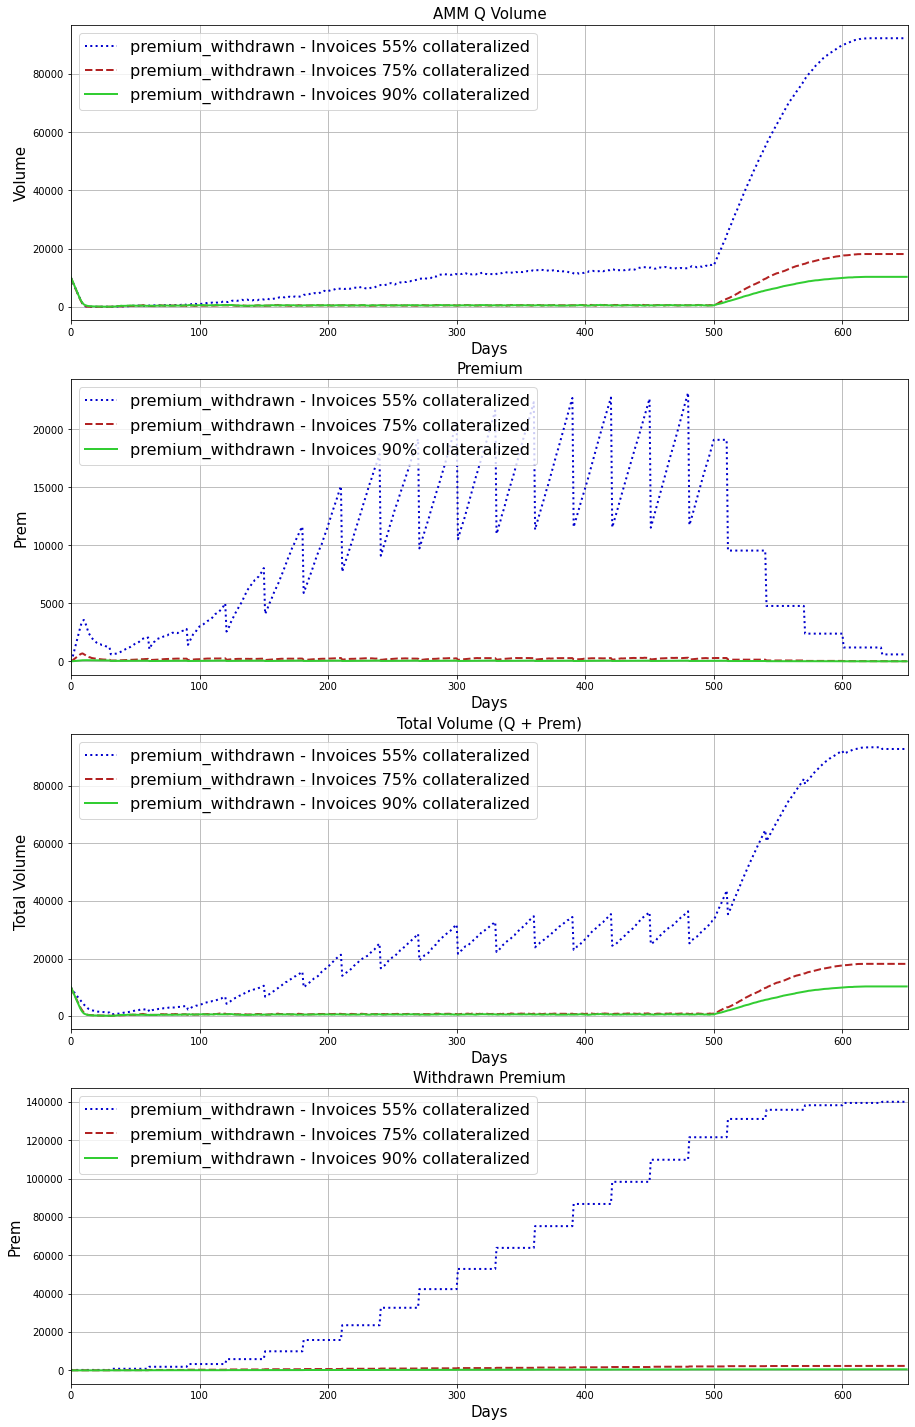

In [15]:
def aux_scenario5(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_5(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Invoices {int(i*100)}% collateralized"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario5(values_scenario5)
reset()

### Hack Scenario simulation

Hack Scenario. Hack prob. 10.0 % with invoices 51.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),499.9,498.25,-0.33%
4,% of accepted invoices (collateralized),99.98,99.65,-0.33%
5,Average of paid invoices (capital returned),449.7,447.98,-0.38%
6,% of paid invoices (capital returned),89.96,89.91,-0.06%
7,Average of unpaid invoices (capital not returned),50.2,50.27,0.14%
8,% of unpaid invoices (capital not returned),10.04,10.09,0.5%
9,Average loss due to unpaid invoices,"52,050.55","52,758.24",1.36%


Hack Scenario. Hack prob. 10.0 % with invoices 70.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),166.06,149.9,-9.73%
4,% of accepted invoices (collateralized),33.21,29.98,-9.73%
5,Average of paid invoices (capital returned),149.92,135.26,-9.78%
6,% of paid invoices (capital returned),90.28,90.23,-0.06%
7,Average of unpaid invoices (capital not returned),16.14,14.64,-9.29%
8,% of unpaid invoices (capital not returned),9.72,9.77,0.51%
9,Average loss due to unpaid invoices,"10,404.49","9,240.75",-11.18%


Hack Scenario. Hack prob. 10.0 % with invoices 90.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),93.59,92.31,-1.37%
4,% of accepted invoices (collateralized),18.72,18.46,-1.39%
5,Average of paid invoices (capital returned),84.26,83.06,-1.42%
6,% of paid invoices (capital returned),90.03,89.98,-0.06%
7,Average of unpaid invoices (capital not returned),9.33,9.25,-0.86%
8,% of unpaid invoices (capital not returned),9.97,10.02,0.5%
9,Average loss due to unpaid invoices,"5,370.67","5,164.15",-3.85%


Hack Scenario. Hack prob. 50.0 % with invoices 51.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),499.93,497.09,-0.57%
4,% of accepted invoices (collateralized),99.99,99.42,-0.57%
5,Average of paid invoices (capital returned),248.55,248.25,-0.12%
6,% of paid invoices (capital returned),49.72,49.94,0.44%
7,Average of unpaid invoices (capital not returned),251.38,248.84,-1.01%
8,% of unpaid invoices (capital not returned),50.28,50.06,-0.44%
9,Average loss due to unpaid invoices,"263,674.8","258,851.53",-1.83%


Hack Scenario. Hack prob. 50.0 % with invoices 70.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),53.24,45.71,-14.14%
4,% of accepted invoices (collateralized),10.65,9.14,-14.18%
5,Average of paid invoices (capital returned),26.16,22.48,-14.07%
6,% of paid invoices (capital returned),49.14,49.18,0.08%
7,Average of unpaid invoices (capital not returned),27.08,23.23,-14.22%
8,% of unpaid invoices (capital not returned),50.86,50.82,-0.08%
9,Average loss due to unpaid invoices,"14,296.05","13,009.73",-9.0%


Hack Scenario. Hack prob. 50.0 % with invoices 90.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),34.55,33.42,-3.27%
4,% of accepted invoices (collateralized),6.91,6.68,-3.33%
5,Average of paid invoices (capital returned),17.07,16.62,-2.64%
6,% of paid invoices (capital returned),49.41,49.73,0.65%
7,Average of unpaid invoices (capital not returned),17.48,16.8,-3.89%
8,% of unpaid invoices (capital not returned),50.59,50.27,-0.63%
9,Average loss due to unpaid invoices,"10,063.94","9,875.29",-1.87%


Hack Scenario. Hack prob. 100.0 % with invoices 51.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),495.01,464.01,-6.26%
4,% of accepted invoices (collateralized),99.0,92.8,-6.26%
5,Average of paid invoices (capital returned),0.0,0.0,0.0%
6,% of paid invoices (capital returned),0.0,0.0,0.0%
7,Average of unpaid invoices (capital not returned),495.01,464.01,-6.26%
8,% of unpaid invoices (capital not returned),100.0,100.0,0.0%
9,Average loss due to unpaid invoices,"515,114.5","469,998.16",-8.76%


Hack Scenario. Hack prob. 100.0 % with invoices 70.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),13.5,12.77,-5.41%
4,% of accepted invoices (collateralized),2.7,2.55,-5.56%
5,Average of paid invoices (capital returned),0.0,0.0,0.0%
6,% of paid invoices (capital returned),0.0,0.0,0.0%
7,Average of unpaid invoices (capital not returned),13.5,12.77,-5.41%
8,% of unpaid invoices (capital not returned),100.0,100.0,0.0%
9,Average loss due to unpaid invoices,"11,720.13","11,531.39",-1.61%


Hack Scenario. Hack prob. 100.0 % with invoices 90.0 % collateralized


,Description,No Premium Withdrawn,Premium Withdrawn,Premium vs. No Premium Withdrawn
0,Number of simulations,100.0,100.0,0.0%
1,Simulation time period (days),650.0,650.0,0.0%
2,Total of invoices,500.0,500.0,0.0%
3,Average of accepted invoices (collateralized),11.1,11.09,-0.09%
4,% of accepted invoices (collateralized),2.22,2.22,0.0%
5,Average of paid invoices (capital returned),0.0,0.0,0.0%
6,% of paid invoices (capital returned),0.0,0.0,0.0%
7,Average of unpaid invoices (capital not returned),11.1,11.09,-0.09%
8,% of unpaid invoices (capital not returned),100.0,100.0,0.0%
9,Average loss due to unpaid invoices,"10,073.81","10,034.84",-0.39%


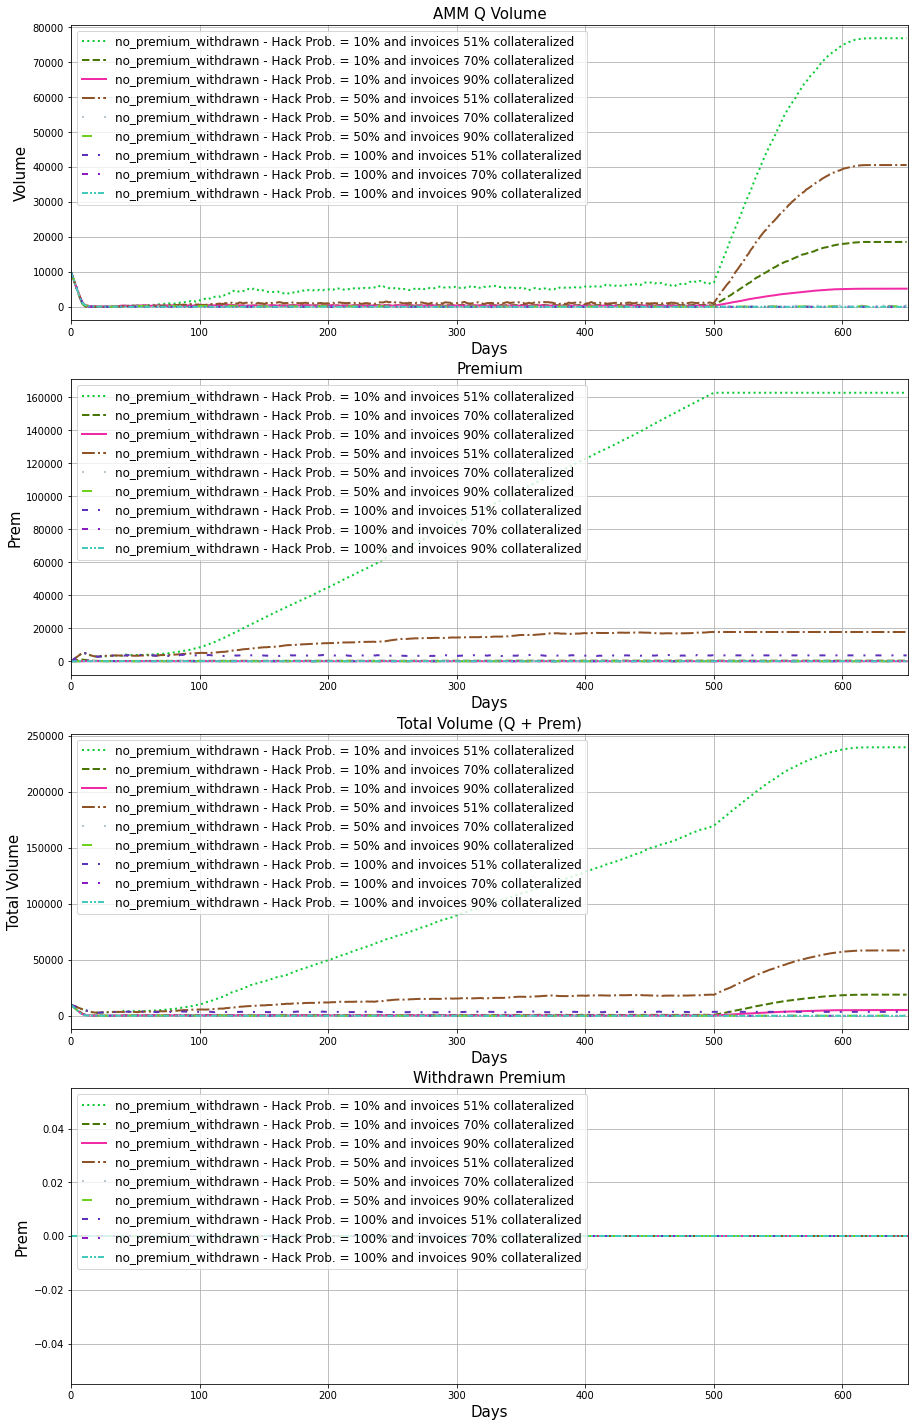

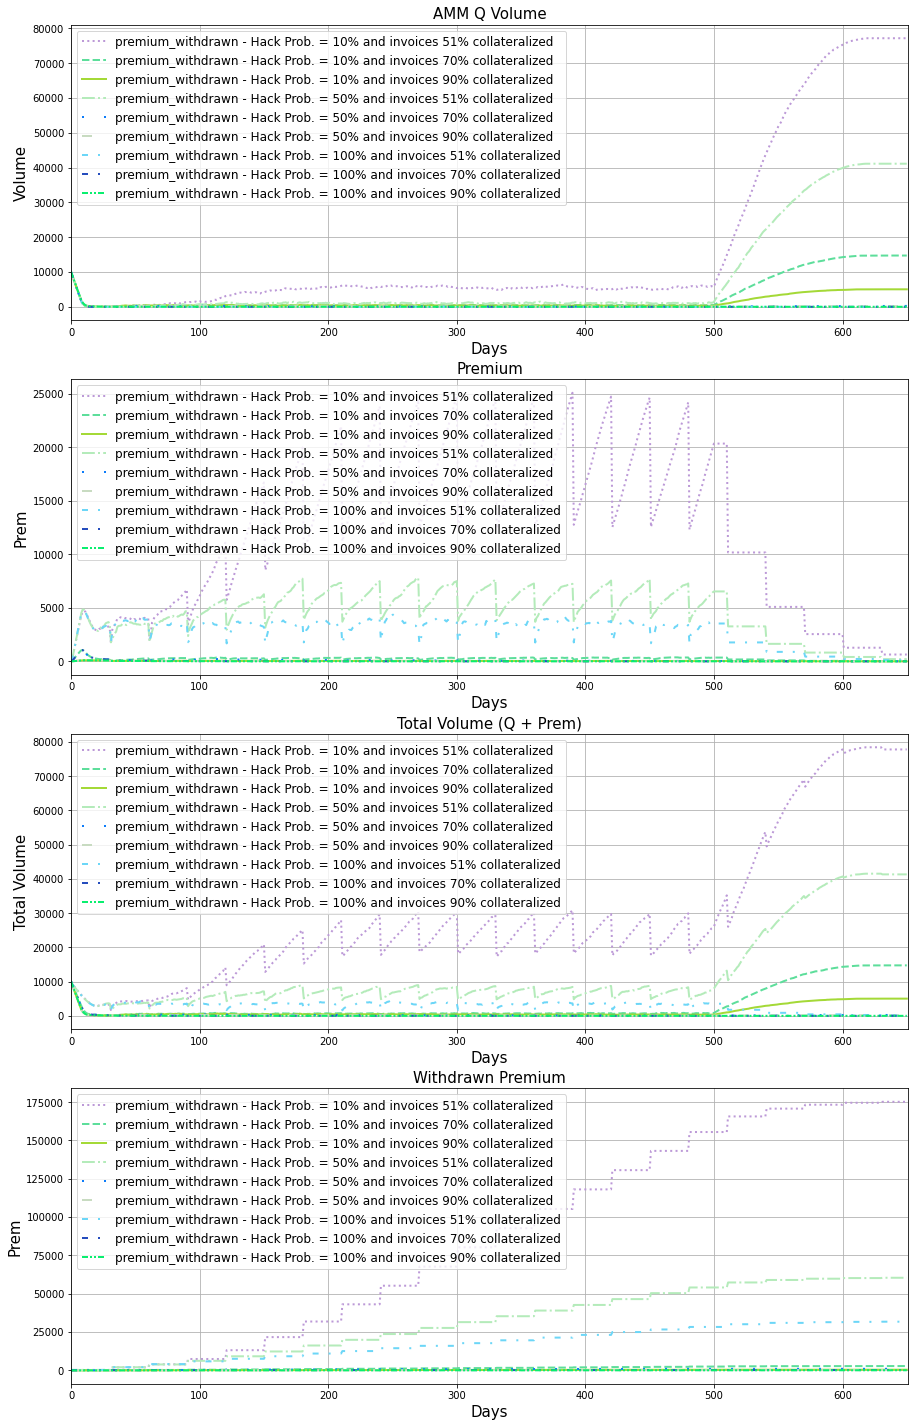

In [16]:
def aux_hack_scenario(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        hack_scenario(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
            linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0,(5,10)), (0, (3,5,1,5)), (0, (3,5,1,5,1,5)), (0, (3,1,1,1,1,1))]

            label_value = f"{sim_name} - Hack Prob. = {int(i[0]*100)}% and invoices {int(i[1]*100)}% collateralized"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

    plt.show()

aux_hack_scenario(values_hack_scenario)
reset()